In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [4]:
# Function to download stock data
def download_stock_data(stocks, start_date, end_date):
    data = yf.download(stocks, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)
    return {ticker: data[ticker]['Close'].dropna() for ticker in stocks}

# Function to create segments
def create_segments(data, window_size=100, overlap=0.5):
    step = int(window_size * (1 - overlap))  # Calculate step size based on overlap
    segments = []
    for ticker, series in data.items():
        series = series.to_numpy()
        for i in range(0, len(series) - window_size + 1, step):
            segment = series[i:i + window_size]
            segments.append({'ticker': ticker, 'segment': segment})
    return segments

# Function to generate and save spectrograms
def generate_and_save_spectrograms(segments, output_dir, wavelet='cmor', scale_range=(1, 64)):
    for idx, segment_data in enumerate(segments):
        ticker = segment_data['ticker']
        segment = segment_data['segment']
        
        # Create folder for each stock if it doesn't exist
        ticker_dir = os.path.join(output_dir, ticker)
        os.makedirs(ticker_dir, exist_ok=True)
        
        # Generate Continuous Wavelet Transform (CWT)
        scales = np.arange(scale_range[0], scale_range[1])
        coefficients, frequencies = pywt.cwt(segment, scales, wavelet)
        
        # Save the spectrogram
        plt.figure(figsize=(8, 6))
        plt.imshow(
            np.abs(coefficients), 
            extent=[0, len(segment), scale_range[0], scale_range[1]], 
            cmap='jet', 
            aspect='auto', 
            origin='lower'
        )
        plt.colorbar(label='Magnitude')
        plt.title(f"Spectrogram - {ticker} - Segment {idx}")
        plt.xlabel("Time")
        plt.ylabel("Scale")
        
        # Save the image
        filename = os.path.join(ticker_dir, f"{ticker}_segment_{idx}.png")
        plt.savefig(filename)
        plt.close()

# Define stock names and date ranges
stocks = ["MSTR", "AAPL", "TSLA", "INTC", "MCD", "KO", "NKE"]
train_start_date = "2003-01-01"
train_end_date = "2016-12-31"
test_start_date = "2017-01-01"
test_end_date = "2019-12-31"

# Directories for saving spectrograms
train_output_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_output_dir = "/Users/roberto/Desktop/cartella senza nome/test"

# Download data for training and testing
train_data = download_stock_data(stocks, train_start_date, train_end_date)
test_data = download_stock_data(stocks, test_start_date, test_end_date)

# Generate segments for training and testing
train_segments = create_segments(train_data, window_size=100, overlap=0.5)
test_segments = create_segments(test_data, window_size=100, overlap=0.5)

# Generate and save spectrograms
generate_and_save_spectrograms(train_segments, train_output_dir)
generate_and_save_spectrograms(test_segments, test_output_dir)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
/Users/roberto/.pyenv/versions/3.11.6/lib/python3.11/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


In [7]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace

In [8]:
def augment_spectrogram(spectrogram, augmentation_type):
    if augmentation_type == "gaussian_blur":
        return gaussian_filter(spectrogram, sigma=1)  # Apply Gaussian Blur
    elif augmentation_type == "laplacian":
        return laplace(spectrogram)  # Apply Laplacian Filter
    elif augmentation_type == "white_noise":
        noise = np.random.normal(0, 0.05, spectrogram.shape)  # Add White Noise
        return spectrogram + noise
    elif augmentation_type == "grayscale":
        return np.mean(spectrogram, axis=0, keepdims=True)  # Convert to grayscale (ensure 2D)
    elif augmentation_type == "time_shift":
        shift = np.random.randint(-10, 10)  # Random horizontal shift
        return np.roll(spectrogram, shift, axis=1)  # Roll along time axis
    elif augmentation_type == "frequency_mask":
        spectrogram = spectrogram.copy()
        freq_dim = spectrogram.shape[0]
        start = np.random.randint(0, freq_dim - 10)
        spectrogram[start:start + 10, :] = 0  # Mask random frequency bands
        return spectrogram
    elif augmentation_type == "time_mask":
        spectrogram = spectrogram.copy()
        time_dim = spectrogram.shape[1]
        start = np.random.randint(0, time_dim - 10)
        spectrogram[:, start:start + 10] = 0  # Mask random time intervals
        return spectrogram
    return spectrogram

def generate_and_save_augmented_spectrograms(segments, output_dir, wavelet='cmor', scale_range=(1, 64), augmentations_per_spectrogram=10):
    augmentation_types = ["gaussian_blur", "laplacian", "white_noise", "grayscale", "time_shift", "frequency_mask", "time_mask"]
    
    for idx, segment_data in enumerate(segments):
        ticker = segment_data['ticker']
        segment = segment_data['segment']

        # Create folder for each stock if it doesn't exist
        ticker_dir = os.path.join(output_dir, ticker)
        os.makedirs(ticker_dir, exist_ok=True)

        # Generate Continuous Wavelet Transform (CWT)
        scales = np.arange(scale_range[0], scale_range[1])
        coefficients, frequencies = pywt.cwt(segment, scales, wavelet)

        original_spectrogram = np.abs(coefficients)

        # Save original spectrogram (if needed)
        filename = os.path.join(ticker_dir, f"{ticker}_segment_{idx}.png")
        plt.figure(figsize=(8, 6))
        plt.imshow(
            original_spectrogram,
            extent=[0, len(segment), scale_range[0], scale_range[1]],
            cmap='jet',
            aspect='auto',
            origin='lower'
        )
        plt.colorbar(label='Magnitude')
        plt.title(f"Spectrogram - {ticker} - Segment {idx}")
        plt.xlabel("Time")
        plt.ylabel("Scale")
        plt.savefig(filename)
        plt.close()

        # Generate augmented spectrograms
        for aug_idx in range(augmentations_per_spectrogram):
            augmentation_type = np.random.choice(augmentation_types)
            augmented_spectrogram = augment_spectrogram(original_spectrogram, augmentation_type)

            # Debugging shape
            print(f"Augmentation Type: {augmentation_type}, Spectrogram Shape: {augmented_spectrogram.shape}")

            # Ensure augmented_spectrogram is 2D
            if len(augmented_spectrogram.shape) != 2:
                print(f"Error: Augmented spectrogram is not 2D (shape: {augmented_spectrogram.shape}).")
                continue

            # Save augmented spectrogram
            aug_filename = os.path.join(ticker_dir, f"{ticker}_segment_{idx}_aug_{aug_idx}.png")
            plt.figure(figsize=(8, 6))
            plt.imshow(
                augmented_spectrogram,
                extent=[0, len(segment), scale_range[0], scale_range[1]],
                cmap='jet',
                aspect='auto',
                origin='lower'
            )
            plt.colorbar(label='Magnitude')
            plt.title(f"Augmented Spectrogram - {ticker} - Segment {idx} - {augmentation_type}")
            plt.xlabel("Time")
            plt.ylabel("Scale")
            plt.savefig(aug_filename)
            plt.close()

# Define stock names and date ranges
stocks = ["MSTR", "AAPL", "TSLA", "INTC", "MCD", "KO", "NKE"]
train_start_date = "2003-01-01"
train_end_date = "2016-12-31"
test_start_date = "2017-01-01"
test_end_date = "2019-12-31"

# Directories for saving spectrograms
train_output_dir = train_output_dir
test_output_dir = test_output_dir

# Assume segments have already been created
# If not, download data and generate segments using the previously defined functions
# train_segments = create_segments(train_data, window_size=100, overlap=0.5)
# test_segments = create_segments(test_data, window_size=100, overlap=0.5)

# Generate and save augmented spectrograms
generate_and_save_augmented_spectrograms(train_segments, train_output_dir, augmentations_per_spectrogram=10)
generate_and_save_augmented_spectrograms(test_segments, test_output_dir, augmentations_per_spectrogram=10)

Augmentation Type: gaussian_blur, Spectrogram Shape: (63, 100)
Augmentation Type: time_shift, Spectrogram Shape: (63, 100)
Augmentation Type: frequency_mask, Spectrogram Shape: (63, 100)
Augmentation Type: gaussian_blur, Spectrogram Shape: (63, 100)
Augmentation Type: grayscale, Spectrogram Shape: (1, 100)
Augmentation Type: white_noise, Spectrogram Shape: (63, 100)
Augmentation Type: white_noise, Spectrogram Shape: (63, 100)
Augmentation Type: laplacian, Spectrogram Shape: (63, 100)
Augmentation Type: grayscale, Spectrogram Shape: (1, 100)
Augmentation Type: time_shift, Spectrogram Shape: (63, 100)
Augmentation Type: time_shift, Spectrogram Shape: (63, 100)
Augmentation Type: laplacian, Spectrogram Shape: (63, 100)
Augmentation Type: frequency_mask, Spectrogram Shape: (63, 100)
Augmentation Type: grayscale, Spectrogram Shape: (1, 100)
Augmentation Type: gaussian_blur, Spectrogram Shape: (63, 100)
Augmentation Type: frequency_mask, Spectrogram Shape: (63, 100)
Augmentation Type: white_

In [21]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, laplace

In [24]:
# Set MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [25]:
print(device)

mps


In [33]:
# Define label map
label_map = {
    'AAPL': 0,
    'INTC': 1,
    'KO': 2,
    'MCD': 3,
    'MSTR': 4,
    'NKE': 5,
    'TSLA': 6
}

 # Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label in label_map.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label




In [32]:

# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [34]:
# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [35]:

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare dataset and loaders
train_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_dir = "/Users/roberto/Desktop/cartella senza nome/test"

train_dataset = SpectrogramDataset(train_dir, label_map, transform=transform)
test_dataset = SpectrogramDataset(test_dir, label_map, transform=transform)

train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer
num_classes = len(label_map)
model = SpectrogramCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc.double() / len(train_loader.dataset):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc.double() / len(val_loader.dataset):.4f}")
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [ ]:

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
    print(f"Test Accuracy: {test_acc.double() / len(test_loader.dataset):.4f}")

evaluate_model(model, test_loader)

In [38]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, laplace

# Set MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define label map
label_map = {
    'AAPL': 0,
    'INTC': 1,
    'KO': 2,
    'MCD': 3,
    'MSTR': 4,
    'NKE': 5,
    'TSLA': 6
}

# Data augmentation
def augment_spectrogram(spectrogram, augmentation_type):
    if augmentation_type == "gaussian_blur":
        return gaussian_filter(spectrogram, sigma=1)
    elif augmentation_type == "laplacian":
        return laplace(spectrogram)
    elif augmentation_type == "white_noise":
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        return spectrogram + noise
    elif augmentation_type == "grayscale":
        return np.mean(spectrogram, axis=0, keepdims=True)
    elif augmentation_type == "time_shift":
        shift = np.random.randint(-10, 10)
        return np.roll(spectrogram, shift, axis=1)
    elif augmentation_type == "frequency_mask":
        spectrogram = spectrogram.copy()
        freq_dim = spectrogram.shape[0]
        start = np.random.randint(0, freq_dim - 10)
        spectrogram[start:start + 10, :] = 0
        return spectrogram
    elif augmentation_type == "time_mask":
        spectrogram = spectrogram.copy()
        time_dim = spectrogram.shape[1]
        start = np.random.randint(0, time_dim - 10)
        spectrogram[:, start:start + 10] = 0
        return spectrogram
    return spectrogram

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label in label_map.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare dataset and loaders
train_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_dir = "/Users/roberto/Desktop/cartella senza nome/test"

train_dataset = SpectrogramDataset(train_dir, label_map, transform=transform)
test_dataset = SpectrogramDataset(test_dir, label_map, transform=transform)

train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer
num_classes = len(label_map)
model = SpectrogramCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels).float()  # Explicitly convert to float32

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels).float()  # Explicitly convert to float32

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc / len(train_loader.dataset):.4f}, "  # Ensure division remains in float32
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc / len(val_loader.dataset):.4f}")  # Ensure division remains in float32

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
    print(f"Test Accuracy: {test_acc.double() / len(test_loader.dataset):.4f}")

evaluate_model(model, test_loader)

Using device: mps
Epoch 1/10, Train Loss: 1.9376, Train Acc: 0.1839, Val Loss: 1.8563, Val Acc: 0.2380
Epoch 2/10, Train Loss: 1.8041, Train Acc: 0.2482, Val Loss: 1.7732, Val Acc: 0.2962
Epoch 3/10, Train Loss: 1.7633, Train Acc: 0.2727, Val Loss: 1.7274, Val Acc: 0.2840
Epoch 4/10, Train Loss: 1.7346, Train Acc: 0.2709, Val Loss: 1.7014, Val Acc: 0.3381
Epoch 5/10, Train Loss: 1.6931, Train Acc: 0.2985, Val Loss: 1.6774, Val Acc: 0.3126
Epoch 6/10, Train Loss: 1.6490, Train Acc: 0.3195, Val Loss: 1.6511, Val Acc: 0.3187
Epoch 7/10, Train Loss: 1.6428, Train Acc: 0.3126, Val Loss: 1.6462, Val Acc: 0.3156
Epoch 8/10, Train Loss: 1.6003, Train Acc: 0.3315, Val Loss: 1.6024, Val Acc: 0.3401
Epoch 9/10, Train Loss: 1.5648, Train Acc: 0.3493, Val Loss: 1.5819, Val Acc: 0.3524
Epoch 10/10, Train Loss: 1.5260, Train Acc: 0.3631, Val Loss: 1.5943, Val Acc: 0.3473


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [48]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, laplace

# Set MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define label map
label_map = {
    'AAPL': 0,
    'INTC': 1,
    'KO': 2,
    'MCD': 3,
    'MSTR': 4,
    'NKE': 5,
    'TSLA': 6
}

# Data augmentation
def augment_spectrogram(spectrogram, augmentation_type):
    if augmentation_type == "gaussian_blur":
        return gaussian_filter(spectrogram, sigma=1)
    elif augmentation_type == "laplacian":
        return laplace(spectrogram)
    elif augmentation_type == "white_noise":
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        return spectrogram + noise
    elif augmentation_type == "grayscale":
        return np.mean(spectrogram, axis=0, keepdims=True)
    elif augmentation_type == "time_shift":
        shift = np.random.randint(-10, 10)
        return np.roll(spectrogram, shift, axis=1)
    elif augmentation_type == "frequency_mask":
        spectrogram = spectrogram.copy()
        freq_dim = spectrogram.shape[0]
        start = np.random.randint(0, freq_dim - 10)
        spectrogram[start:start + 10, :] = 0
        return spectrogram
    elif augmentation_type == "time_mask":
        spectrogram = spectrogram.copy()
        time_dim = spectrogram.shape[1]
        start = np.random.randint(0, time_dim - 10)
        spectrogram[:, start:start + 10] = 0
        return spectrogram
    return spectrogram

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label in label_map.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare dataset and loaders
train_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_dir = "/Users/roberto/Desktop/cartella senza nome/test"

train_dataset = SpectrogramDataset(train_dir, label_map, transform=transform)
test_dataset = SpectrogramDataset(test_dir, label_map, transform=transform)

train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer
num_classes = len(label_map)
model = SpectrogramCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels).float()  # Ensure float32

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels).float()  # Ensure float32

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc / len(train_loader.dataset):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc / len(val_loader.dataset):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels).float()  # Ensure float32
    print(f"Test Accuracy: {test_acc / len(test_loader.dataset):.4f}")  # Ensure float32

evaluate_model(model, test_loader)

Using device: mps
Epoch 1/25, Train Loss: 1.9513, Train Acc: 0.1752, Val Loss: 1.9016, Val Acc: 0.2114
Epoch 2/25, Train Loss: 1.8344, Train Acc: 0.2283, Val Loss: 1.7968, Val Acc: 0.2390
Epoch 3/25, Train Loss: 1.7593, Train Acc: 0.2610, Val Loss: 1.7677, Val Acc: 0.2646
Epoch 4/25, Train Loss: 1.7399, Train Acc: 0.2753, Val Loss: 1.7396, Val Acc: 0.2891
Epoch 5/25, Train Loss: 1.7106, Train Acc: 0.2886, Val Loss: 1.7146, Val Acc: 0.2809
Epoch 6/25, Train Loss: 1.6914, Train Acc: 0.2993, Val Loss: 1.6880, Val Acc: 0.2962
Epoch 7/25, Train Loss: 1.6482, Train Acc: 0.3075, Val Loss: 1.6815, Val Acc: 0.3095
Epoch 8/25, Train Loss: 1.6149, Train Acc: 0.3128, Val Loss: 1.6440, Val Acc: 0.3248
Epoch 9/25, Train Loss: 1.5832, Train Acc: 0.3327, Val Loss: 1.6132, Val Acc: 0.3320
Epoch 10/25, Train Loss: 1.5439, Train Acc: 0.3516, Val Loss: 1.5737, Val Acc: 0.3636
Epoch 11/25, Train Loss: 1.4988, Train Acc: 0.3659, Val Loss: 1.5957, Val Acc: 0.3330
Epoch 12/25, Train Loss: 1.4574, Train Acc: 0

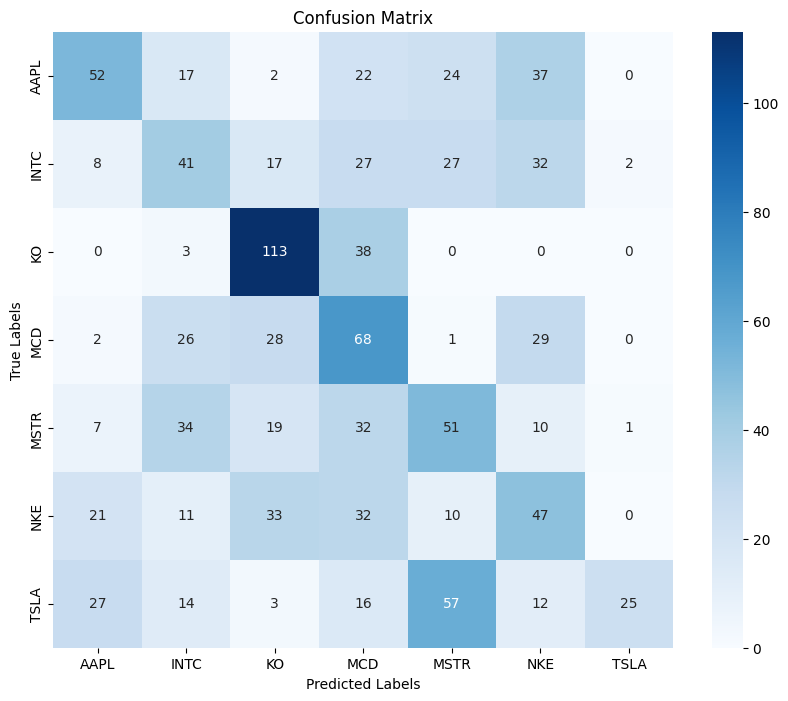

Classification Report:
              precision    recall  f1-score   support

        AAPL       0.44      0.34      0.38       154
        INTC       0.28      0.27      0.27       154
          KO       0.53      0.73      0.61       154
         MCD       0.29      0.44      0.35       154
        MSTR       0.30      0.33      0.31       154
         NKE       0.28      0.31      0.29       154
        TSLA       0.89      0.16      0.27       154

    accuracy                           0.37      1078
   macro avg       0.43      0.37      0.36      1078
weighted avg       0.43      0.37      0.36      1078

Accuracy: 0.3683


In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_with_metrics(model, test_loader, label_map):
    model.eval()
    all_preds = []
    all_labels = []

    # Gather predictions and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map numeric labels to class names
    class_names = {v: k for k, v in label_map.items()}

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names.values()))

    # Compute and print accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model_with_metrics(model, test_loader, label_map)

In [50]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, laplace

# Set MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define label map
label_map = {
    'AAPL': 0,
    'INTC': 1,
    'KO': 2,
    'MCD': 3,
    'MSTR': 4,
    'NKE': 5,
    'TSLA': 6
}

# Data augmentation
def augment_spectrogram(spectrogram, augmentation_type):
    if augmentation_type == "gaussian_blur":
        return gaussian_filter(spectrogram, sigma=1)
    elif augmentation_type == "laplacian":
        return laplace(spectrogram)
    elif augmentation_type == "white_noise":
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        return spectrogram + noise
    elif augmentation_type == "grayscale":
        return np.mean(spectrogram, axis=0, keepdims=True)
    elif augmentation_type == "time_shift":
        shift = np.random.randint(-10, 10)
        return np.roll(spectrogram, shift, axis=1)
    elif augmentation_type == "frequency_mask":
        spectrogram = spectrogram.copy()
        freq_dim = spectrogram.shape[0]
        start = np.random.randint(0, freq_dim - 10)
        spectrogram[start:start + 10, :] = 0
        return spectrogram
    elif augmentation_type == "time_mask":
        spectrogram = spectrogram.copy()
        time_dim = spectrogram.shape[1]
        start = np.random.randint(0, time_dim - 10)
        spectrogram[:, start:start + 10] = 0
        return spectrogram
    return spectrogram

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label in label_map.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare dataset and loaders
train_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_dir = "/Users/roberto/Desktop/cartella senza nome/test"

train_dataset = SpectrogramDataset(train_dir, label_map, transform=transform)
test_dataset = SpectrogramDataset(test_dir, label_map, transform=transform)

train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer
num_classes = len(label_map)
model = SpectrogramCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels).float()  # Ensure float32

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels).float()  # Ensure float32

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc / len(train_loader.dataset):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc / len(val_loader.dataset):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=35)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels).float()  # Ensure float32
    print(f"Test Accuracy: {test_acc / len(test_loader.dataset):.4f}")  # Ensure float32

evaluate_model(model, test_loader)

Using device: mps
Epoch 1/35, Train Loss: 1.9822, Train Acc: 0.1586, Val Loss: 1.9118, Val Acc: 0.1971
Epoch 2/35, Train Loss: 1.8843, Train Acc: 0.2104, Val Loss: 1.8253, Val Acc: 0.2594
Epoch 3/35, Train Loss: 1.8254, Train Acc: 0.2451, Val Loss: 1.7978, Val Acc: 0.2441
Epoch 4/35, Train Loss: 1.7977, Train Acc: 0.2538, Val Loss: 1.7816, Val Acc: 0.2819
Epoch 5/35, Train Loss: 1.7687, Train Acc: 0.2671, Val Loss: 1.7487, Val Acc: 0.2860
Epoch 6/35, Train Loss: 1.7462, Train Acc: 0.2748, Val Loss: 1.7437, Val Acc: 0.2952
Epoch 7/35, Train Loss: 1.7291, Train Acc: 0.2835, Val Loss: 1.7293, Val Acc: 0.2697
Epoch 8/35, Train Loss: 1.7150, Train Acc: 0.2942, Val Loss: 1.7248, Val Acc: 0.2737
Epoch 9/35, Train Loss: 1.6936, Train Acc: 0.3001, Val Loss: 1.7176, Val Acc: 0.3003
Epoch 10/35, Train Loss: 1.6743, Train Acc: 0.3062, Val Loss: 1.7064, Val Acc: 0.2972
Epoch 11/35, Train Loss: 1.6552, Train Acc: 0.3182, Val Loss: 1.6651, Val Acc: 0.3197
Epoch 12/35, Train Loss: 1.6202, Train Acc: 0

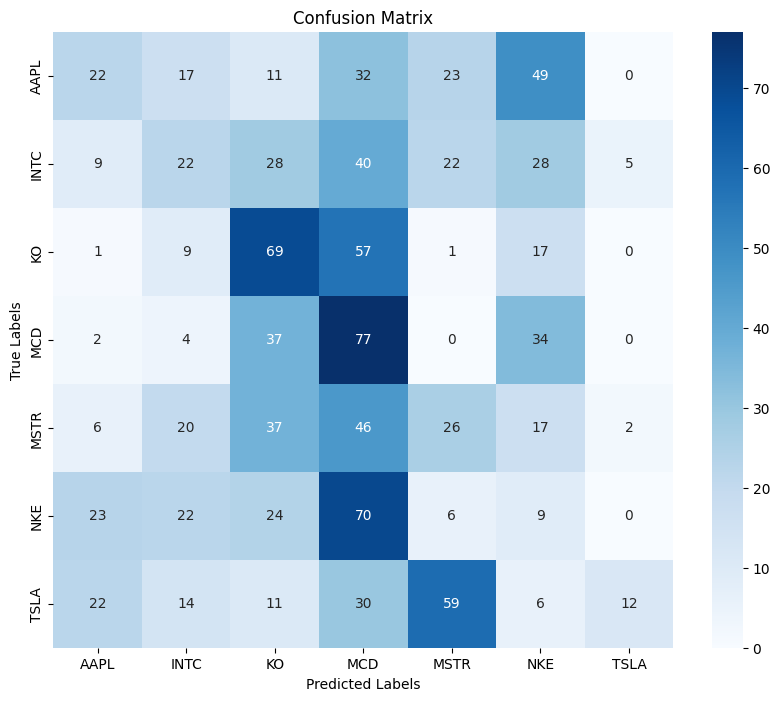

Classification Report:
              precision    recall  f1-score   support

        AAPL       0.26      0.14      0.18       154
        INTC       0.20      0.14      0.17       154
          KO       0.32      0.45      0.37       154
         MCD       0.22      0.50      0.30       154
        MSTR       0.19      0.17      0.18       154
         NKE       0.06      0.06      0.06       154
        TSLA       0.63      0.08      0.14       154

    accuracy                           0.22      1078
   macro avg       0.27      0.22      0.20      1078
weighted avg       0.27      0.22      0.20      1078

Accuracy: 0.2199


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_with_metrics(model, test_loader, label_map):
    model.eval()
    all_preds = []
    all_labels = []

    # Gather predictions and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map numeric labels to class names
    class_names = {v: k for k, v in label_map.items()}

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names.values()))

    # Compute and print accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model_with_metrics(model, test_loader, label_map)

In [52]:
import os
import numpy as np
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter, laplace

# Set MPS device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Define label map
label_map = {
    'AAPL': 0,
    'INTC': 1,
    'KO': 2,
    'MCD': 3,
    'MSTR': 4,
    'NKE': 5,
    'TSLA': 6
}

# Data augmentation
def augment_spectrogram(spectrogram, augmentation_type):
    if augmentation_type == "gaussian_blur":
        return gaussian_filter(spectrogram, sigma=1)
    elif augmentation_type == "laplacian":
        return laplace(spectrogram)
    elif augmentation_type == "white_noise":
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        return spectrogram + noise
    elif augmentation_type == "grayscale":
        return np.mean(spectrogram, axis=0, keepdims=True)
    elif augmentation_type == "time_shift":
        shift = np.random.randint(-10, 10)
        return np.roll(spectrogram, shift, axis=1)
    elif augmentation_type == "frequency_mask":
        spectrogram = spectrogram.copy()
        freq_dim = spectrogram.shape[0]
        start = np.random.randint(0, freq_dim - 10)
        spectrogram[start:start + 10, :] = 0
        return spectrogram
    elif augmentation_type == "time_mask":
        spectrogram = spectrogram.copy()
        time_dim = spectrogram.shape[1]
        start = np.random.randint(0, time_dim - 10)
        spectrogram[:, start:start + 10] = 0
        return spectrogram
    return spectrogram

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name, label in label_map.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.exists(folder_path):
                for img_name in os.listdir(folder_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN Model
class SpectrogramCNN(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Prepare dataset and loaders
train_dir = "/Users/roberto/Desktop/cartella senza nome/train"
test_dir = "/Users/roberto/Desktop/cartella senza nome/test"

train_dataset = SpectrogramDataset(train_dir, label_map, transform=transform)
test_dataset = SpectrogramDataset(test_dir, label_map, transform=transform)

train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, optimizer
num_classes = len(label_map)
model = SpectrogramCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels).float()  # Ensure float32

        val_loss, val_acc = 0.0, 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels).float()  # Ensure float32

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_acc / len(train_loader.dataset):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc / len(val_loader.dataset):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels).float()  # Ensure float32
    print(f"Test Accuracy: {test_acc / len(test_loader.dataset):.4f}")  # Ensure float32

evaluate_model(model, test_loader)

Using device: mps
Epoch 1/50, Train Loss: 1.9611, Train Acc: 0.1673, Val Loss: 1.8958, Val Acc: 0.1849
Epoch 2/50, Train Loss: 1.8354, Train Acc: 0.2245, Val Loss: 1.7847, Val Acc: 0.2860
Epoch 3/50, Train Loss: 1.7729, Train Acc: 0.2592, Val Loss: 1.7620, Val Acc: 0.2962
Epoch 4/50, Train Loss: 1.7296, Train Acc: 0.2845, Val Loss: 1.7419, Val Acc: 0.2860
Epoch 5/50, Train Loss: 1.7087, Train Acc: 0.2888, Val Loss: 1.7056, Val Acc: 0.3269
Epoch 6/50, Train Loss: 1.6789, Train Acc: 0.3044, Val Loss: 1.6727, Val Acc: 0.3463
Epoch 7/50, Train Loss: 1.6619, Train Acc: 0.3072, Val Loss: 1.6658, Val Acc: 0.3207
Epoch 8/50, Train Loss: 1.6319, Train Acc: 0.3182, Val Loss: 1.6611, Val Acc: 0.3156
Epoch 9/50, Train Loss: 1.6087, Train Acc: 0.3373, Val Loss: 1.6259, Val Acc: 0.3401
Epoch 10/50, Train Loss: 1.5795, Train Acc: 0.3299, Val Loss: 1.6238, Val Acc: 0.3340
Epoch 11/50, Train Loss: 1.5578, Train Acc: 0.3501, Val Loss: 1.6115, Val Acc: 0.3422
Epoch 12/50, Train Loss: 1.5168, Train Acc: 0

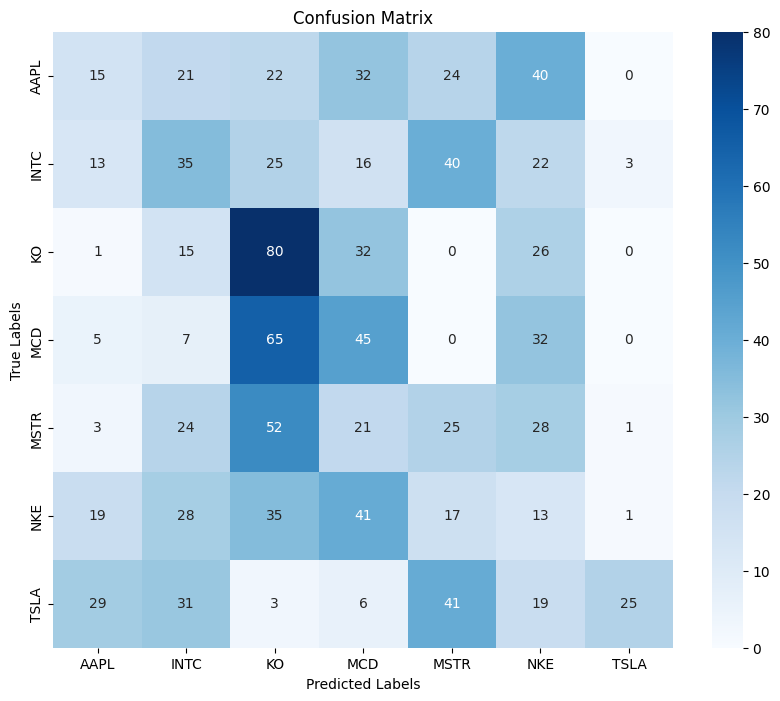

Classification Report:
              precision    recall  f1-score   support

        AAPL       0.18      0.10      0.13       154
        INTC       0.22      0.23      0.22       154
          KO       0.28      0.52      0.37       154
         MCD       0.23      0.29      0.26       154
        MSTR       0.17      0.16      0.17       154
         NKE       0.07      0.08      0.08       154
        TSLA       0.83      0.16      0.27       154

    accuracy                           0.22      1078
   macro avg       0.28      0.22      0.21      1078
weighted avg       0.28      0.22      0.21      1078

Accuracy: 0.2208


In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_with_metrics(model, test_loader, label_map):
    model.eval()
    all_preds = []
    all_labels = []

    # Gather predictions and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Map numeric labels to class names
    class_names = {v: k for k, v in label_map.items()}

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names.values()))

    # Compute and print accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model_with_metrics(model, test_loader, label_map)